In [36]:
from pathlib import Path
from PIL import Image
from typing import Optional, List, Callable
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class FingerprintGumNetDataset(Dataset):
    """
    PyTorch Dataset for 2D GumNet Siamese Training.
    Pairs a noisy impression (Sb) with its uniquely corresponding master template (Sa) found in the pattern's 'master' directory.
    """
    def __init__(self, 
                 root_dir: str, 
                 split: str = 'train', 
                 noise_levels: Optional[List[str]] = None,
                 impression_transform: Optional[Callable] = None,
                 affine_degrees: int = 10,
                 affine_translate: float = 0.1):
        """
        Args:
            root_dir (str): Path to the 'data' directory.
            split (str): One of 'train', 'val', or 'test'.
            noise_levels (list): Specific noise levels to include (e.g., ['Noise_Level_10']). 
                                 If None, uses all available noise levels.
            impression_transform (callable): Transformations applied to Sb.
            affine_degrees (int): Max degrees for random rotation in the affine transform.
            affine_translate (float): Max translation as a fraction of image size for the affine transform.
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.template_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Pad(padding=(62, 0, 63, 0), fill=255),
            transforms.Resize((192, 192)),
            transforms.RandomInvert(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]) 
        ])
        self.impression_transform = impression_transform if impression_transform else transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomAffine(degrees=affine_degrees, translate=(affine_translate, affine_translate), fill=255),
            transforms.Pad(padding=(62, 0, 63, 0), fill=255),
            transforms.Resize((192, 192)),
            transforms.RandomInvert(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]) 
        ])
        self.pairs = []
        self._build_dataset(noise_levels)

    def _build_dataset(self, noise_levels: Optional[List[str]]):
        pattern_classes = [d for d in self.root_dir.iterdir() if d.is_dir()]

        for pattern_dir in pattern_classes:
            master_dir = pattern_dir / 'master'

            try:
                master_path = next(master_dir.glob('*.png'))
            except StopIteration:
                print(f"Warning: No master template found in {master_dir}. Skipping pattern.")
                continue

            subdirs = [d for d in pattern_dir.iterdir() if d.is_dir() and d.name.startswith('Noise_Level')]
            if noise_levels:
                subdirs = [d for d in subdirs if d.name in noise_levels]

            for noise_dir in subdirs:
                split_dir = noise_dir / self.split
                if not split_dir.exists():
                    continue

                for imp_path in split_dir.glob('*.png'):
                    self.pairs.append({
                        'Sa_path': str(master_path),
                        'Sb_path': str(imp_path),
                        'pattern': pattern_dir.name,
                        'noise_level': noise_dir.name
                    })

        print(f"Loaded {len(self.pairs)} {self.split} pairs.")

    def __len__(self) -> int:
        return len(self.pairs)

    def __getitem__(self, idx: int) -> dict:
        pair_info = self.pairs[idx]
        Sa_img = Image.open(pair_info['Sa_path']).convert('L')
        Sb_img = Image.open(pair_info['Sb_path']).convert('L')
        Sa_tensor = self.template_transform(Sa_img)
        Sb_tensor = self.impression_transform(Sb_img)
            
        return {
            'Sa': Sa_tensor,
            'Sb': Sb_tensor,
            'pattern': pair_info['pattern'],
            'noise_level': pair_info['noise_level']
        }

In [37]:
def get_dataloaders(data_root: str, batch_size: int = 16, num_workers: int = 4):
    """
    Instantiates the Train, Val, and Test dataloaders.
    """
    train_dataset = FingerprintGumNetDataset(root_dir=data_root, split='train')
    val_dataset = FingerprintGumNetDataset(root_dir=data_root, split='val')
    test_dataset = FingerprintGumNetDataset(root_dir=data_root, split='test')
    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=num_workers, 
                              pin_memory=True,
                              drop_last=True)
                              
    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers,
                            pin_memory=True)
                            
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             pin_memory=True)
                             
    return train_loader, val_loader, test_loader

In [38]:
DATA_ROOT = "/home/caffeinekeyboard/Codex/CVPR_2026_Biometrics_Workshop/ICML_Workshop_Paper/data"
train_loader, val_loader, test_loader = get_dataloaders(DATA_ROOT, batch_size=16)

for batch in train_loader:
    Sa = batch['Sa']
    Sb = batch['Sb']
    print(f"Sa (Master) Tensor Shape: {Sa.shape}")      # Expected: torch.Size([16, 1, 192, 192])
    print(f"Sb (Impression) Tensor Shape: {Sb.shape}")  # Expected: torch.Size([16, 1, 192, 192])
    print(f"Sample Noise levels in batch: {batch['noise_level']}")
    break

Loaded 52500 train pairs.
Loaded 3500 val pairs.
Loaded 17500 test pairs.
Sa (Master) Tensor Shape: torch.Size([16, 1, 192, 192])
Sb (Impression) Tensor Shape: torch.Size([16, 1, 192, 192])
Sample Noise levels in batch: ['Noise_Level_15', 'Noise_Level_15', 'Noise_Level_20', 'Noise_Level_20', 'Noise_Level_10', 'Noise_Level_20', 'Noise_Level_15', 'Noise_Level_15', 'Noise_Level_5', 'Noise_Level_15', 'Noise_Level_0', 'Noise_Level_20', 'Noise_Level_0', 'Noise_Level_15', 'Noise_Level_0', 'Noise_Level_5']


In [39]:
def visualize_gumnet_batch(dataloader, num_pairs=4, border_color='black', border_width=2):
    """
    Fetches a single batch from the dataloader and visualizes 'num_pairs' of Sa and Sb
    with a distinct border around the images.
    """
    batch = next(iter(dataloader))
    Sa_batch = batch['Sa']
    Sb_batch = batch['Sb']
    patterns = batch['pattern']
    noise_levels = batch['noise_level']
    num_to_display = min(num_pairs, Sa_batch.size(0))
    
    for i in range(num_to_display):
        Sa_tensor = Sa_batch[i]
        Sb_tensor = Sb_batch[i]
        Sa_img = Sa_tensor * 0.5 + 0.5
        Sb_img = Sb_tensor * 0.5 + 0.5
        Sa_img = Sa_img.squeeze(0).numpy()
        Sb_img = Sb_img.squeeze(0).numpy()
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        images = [Sa_img, Sb_img]
        titles = [r"$S_a$ (Master Template)", r"$S_b$ (Impression)"]
        
        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img, cmap='gray')
            ax.set_title(title, pad=10)
            ax.set_xticks([])
            ax.set_yticks([])

            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color(border_color)
                spine.set_linewidth(border_width)

        plt.suptitle(f"Class: {patterns[i]} | Noise: {noise_levels[i]}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

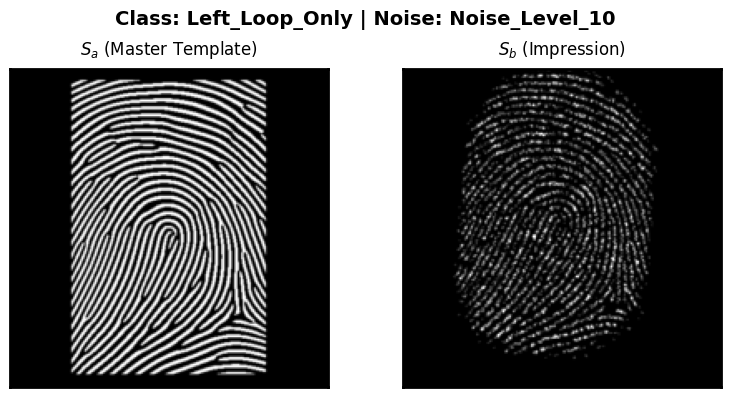

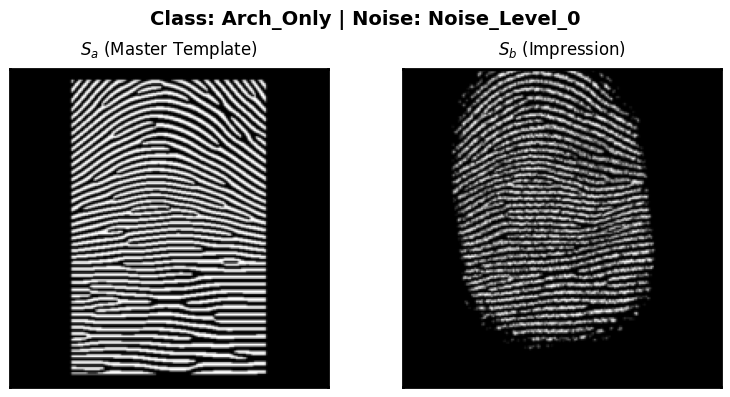

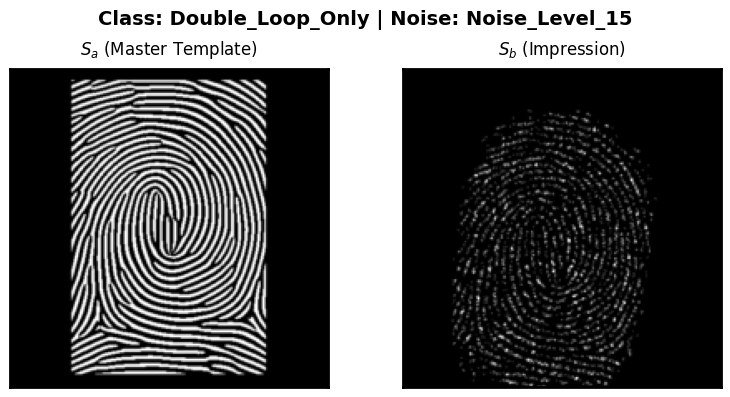

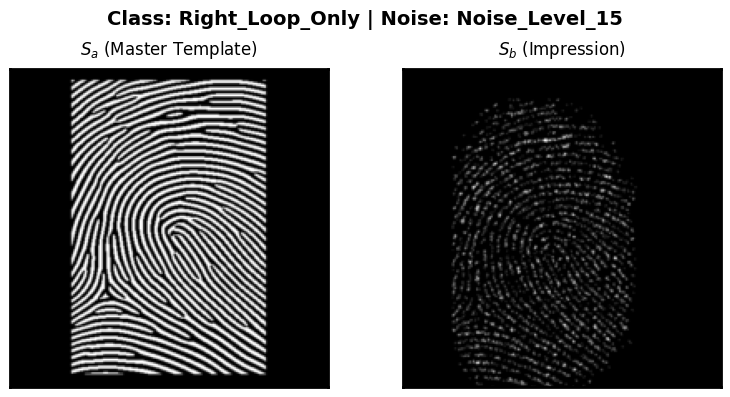

In [40]:
visualize_gumnet_batch(train_loader, num_pairs=4)